<a href="https://colab.research.google.com/github/Flammingo2/TensorFlow/blob/main/homework8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import PIL
import tensorflow_probability as tfp

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [37]:
# Load dataset, split into test and training data
train_ds, test_ds = tfds.load('fashion_mnist', split= ['train', 'test'], data_dir="data\\", as_supervised=True, shuffle_files=True)

In [38]:
def overview_data():
  train_ds_numpy = tfds.as_numpy(train_dataset)
  test_ds_numpy = tfds.as_numpy(test_dataset)

  #Look at shapes images and labels of dataset
  print("length train: ",len(train_dataset))
  print("length train: ",len(test_dataset))

  x = 0
  for i in train_ds_numpy:
    x += 1
    # print(i)
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

  x = 0
  for i in test_ds_numpy:
    x += 1
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

#overview_data()

<Figure size 576x576 with 0 Axes>

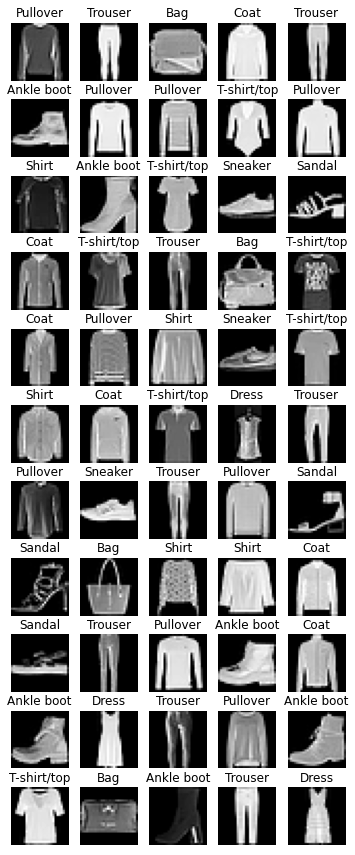

In [39]:
def tile_plot(train,imgs=55,greyscale=True,scale=False,labelling=True):
    # This function plots the images in a tiled fashion, for better visualization.
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 10
    fig, ax = plt.subplots(1,imgs)
    for i,j in enumerate(tfds.as_numpy(train)):
        img= j[0]
        
        label = {
        0 : 'T-shirt/top',
        1 : 'Trouser',
        2 : 'Pullover',
        3 : 'Dress',
        4 : 'Coat',
        5 : 'Sandal',
        6 : 'Shirt',
        7 : 'Sneaker',
        8 : 'Bag',
        9 : 'Ankle boot'
        }
        # if label is still just an integer
        if isinstance(j[1], np.int64):
            if labelling:
                lbl = label[j[1]]
        else:
            indice = np.where(j[1] == 1)
            indice = indice[0]
            if labelling:
                lbl = label[int(indice)]
        subax = fig.add_subplot(rows+1,columns+1,i+1)   
        subax.axis("off")
        if labelling:
            subax.set_title(lbl)

        if greyscale: #Dealing with grayscale images requires a different approach, since imshow doesn't handle them as adroitly as RGB
            if scale: # This is to visualize our normalized images. Since this doesn't conform to the standard scale, we have to define our own
                plt.imshow(np.squeeze(img),vmin=-2, vmax= 2.5,cmap="gray")
            else:
                plt.imshow(tf.cast(np.squeeze(img),tf.uint8),cmap="gray")
        else:
            plt.imshow(tf.cast(img,tf.uint8)) #cast to uint because otherwise there's an error from matplotlib
        ax[i].axis("off")
        if i == (imgs-1): 
            # this is really awkward, but sadly prefetch_datasets are quite particular about indexing.
            # converting them to numpy first might be smarter in the future
            break
    plt.subplots_adjust(top=3)
    plt.show()

tile_plot(train_ds)

In [40]:
train_ds = train_ds.map(lambda image, label: (tf.cast(image/255, tf.float32), tf.reshape(tf.one_hot(label, 10), (-1,))))
test_ds = test_ds.map(lambda image, label: (tf.cast(image/255, tf.float32), tf.reshape(tf.one_hot(label, 10), (-1,))))

prefetch_size = tf.data.experimental.AUTOTUNE

# batching, shuffle und prefetching, batchsize is 32!
train_ds = train_ds.batch(32).shuffle(buffer_size=32).prefetch(prefetch_size)
test_ds = test_ds.batch(32).shuffle(buffer_size=32).prefetch(prefetch_size)

In [41]:
#simple discriminator model, downsamples the input and gives back the probability of input being real
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.hidden = [
      tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.activations.sigmoid(), #14x14x32 #sigmoid instaed of relu?

    tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = 3,
                           strides = 2,
                           activation = None,
                           padding = 'same',
                           kernel_initializer = tf.keras.initializers.glorot_normal,
                           bias_initializer = 'zeros',
                           kernel_regularizer = None),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.activations.sigmoid(), #7x7x32 #sigmoid instead of relu?
       
    tf.keras.layers.Dense(units=1, activation=tf.keras.activations.softmax) #32 #softmax instead of sigmoid? #classification as real is output 1
    ]
    
    
  def call(self, x, training = True):  
    for layer in self.hidden:
      x = layer(x, training = training)

    return x

In [42]:
#takes random noise input and returns picture to fool discriminator

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()

    self.hidden = [
      tf.keras.layers.Reshape((14,14,1)), #14x14x1
      tf.keras.layers.Conv2DTranspose(filters = 16,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None,
                                         input_shape = (32,14,14,1)
                                      ),
      tf.keras.layers.BatchNormalization(),                                         
      tf.keras.activations.relu(), #28x28x16

      tf.keras.layers.Dense(units=32, #Robin hatte 14x14x1 warum?
                            activation=None 
                            ),
      tf.keras.layers.BatchNormalization(),                                         
      tf.keras.activations.relu(),

      tf.keras.layers.Conv2DTranspose(filters = 32,
                                         kernel_size = 4,
                                         strides = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None),
      tf.keras.layers.BatchNormalization(),                                         
      tf.keras.activations.relu(), #28x28x32
      

      tf.keras.layers.Conv2D(filters = 1,
                                         kernel_size = 3,
                                         strides = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None),
      tf.keras.layers.BatchNormalization(),     
      tf.keras.activations.sigmoid()                                    
    ]
    

  def call(self, x, training = True):  
    for layer in self.hidden:
      x = layer(x, training = training)
    return x

In [ ]:
#generator training and test step
def generator_train_step(generator, discriminator, input, target, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    #do forward step
    input = generator(input, training=True)
    #training=False, because no training of the discriminator!
    prediction = discriminator(input, training=False)

    #apply specific loss calculation
    loss = generator_loss(target, prediction) 
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

#TODO test_ds data???
def generator_test_step(generator, discriminator, test_ds, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  generated_data = []

#generate list of generated images
  for data in test_ds:
    generated_data.append(generator(data))
    
  for input in generated_data:  
    #training=False because no training of the discriminator wanted!
    prediction = generator(input, training=False)

    sample_test_loss = generator_loss(prediction) 
    if prediction >= 0.5:
      sample_test_accuracy = 1
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy, generated_data

In [ ]:
#discriminator training and test step
#takes an input image and its related target (if fake or not)!
def discriminator_train_step(discriminator, input, target, optimizer):
  # optimizer_object is instance of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = discriminator(input, training=True)
    loss = discriminator_loss(prediction) 
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

#takes test_data as input, consisting of a test dataset (input, target) including fake and real images
def discriminator_test_step(discriminator, test_data, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = discriminator(input, training=False)
    sample_test_loss = discriminator_loss(prediction) 
    if round_up_down(prediction) == target
      sample_test_accuracy = 1
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
def round_up_down(digit):
  if digit >= 0.5:
    result = 1
  else:
    result = 0

In [ ]:
#LOSS FUNCTIONS from the code snippet
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(prediction): 
  """
  d_pred: discriminator's prediction  of the image generated by the generator  
  take cross entropy between predicted label and all labels as 1s
  because we want to minimize the difference between them
  --> the more the discriminator thinks the images are real, the better our generator
  """
  return bce(tf.ones_like(prediction), prediction) # tf.ones_like(prediction) is same as tf.ones(prediction.shape)


#Ich habs jetzt so verstanden, dass der output einmal zu 1 verglichen wird und einmal zu null, die summe ergibt den loss... 
#aber warum? warum nicht einfach loss zwischen target und prediction?
def discriminator_loss(prediction):
  """
  real_img_lbl: labels that discriminator predicted when seeing real images (should ideally be all 1s)
  fake_img_lbl: labels that discriminator predicted when seeing fake images (should ideally be all 0s)
  """
  real_loss = bce(tf.ones(prediction.shape), prediction)
  fake_loss = bce(tf.zeros(prediction.shape), prediction)

  return real_loss + fake_loss


In [43]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = tf.optimizers.schedules.ExponentialDecay(0.001, 5000, 0.97, staircase=True)
running_average_factor = 0.95

# Initialize the Generator and Discriminator model.
generator = Generator()
discriminator = Discriminator()

#NICHT MEHR GEBRAUCHT?
## Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
#binary_entropy_loss = tf.keras.losses.BinaryCrossentropy()

# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
generator_train_losses = []
discriminator_train_losses = []

generator_test_losses = []
generator_test_accuracies = []
discriminator_test_losses = []
discriminator_test_accuracies = []

#testing before begin?

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (real_input, ) in train_ds:
      real_target = 1
      #create random noise to feed into generator
      fake_target = 0
      #TODO: target(1(real) oder 0(fake)) übergeben, real und fake random übergeben
      #generator_test_step? discriminator_train/test_step?? generated_data an discriminator test/train? übergeben
        generator_train_loss = generator_train_step(generator, discriminator, fake_input, fake_target, optimizer)
        discriminator_train_loss = discriminator_train_step(discriminator, fake_input, fake_target, optimizer)
        running_average_g = running_average_factor_g * running_average_g  + (1 - running_average_factor_g) * generator_train_loss
        running_average_d = running_average_factor_d * running_average_d  + (1 - running_average_factor_d) * discriminator_train_loss

        generator_train_loss = generator_train_step(generator, discriminator, fake_input, fake_target, optimizer)
        discriminator_train_loss = discriminator_train_step(discriminator, real_input, real_target, optimizer)
        running_average_g = running_average_factor_g * running_average_g  + (1 - running_average_factor_g) * generator_train_loss
        running_average_d = running_average_factor_d * running_average_d  + (1 - running_average_factor_d) * discriminator_train_loss

    generator_train_losses.append(running_average_g)
    discriminator_train_losses.append(running_average_d)


    #testing
    #create test dataset, mix of real (10.000) and fake images (10.000)
    #TODO generate 10.000 images
    # TODO test_ds erweitern plus richitge labels und wieder in dataset verwandeln
    test_loss, test_accuracy = generator_test_step(generator, discriminator, test_ds)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #Print accuracy
    print(test_accuracies[-1])

    # Visualize accuracy and loss for training and test data. 
    # One plot training and test loss.
    # One plot training and test accuracy.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("training","test"))
    plt.show()

    plt.figure()
    line1, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()

NameError: ignored

In [42]:
def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    #clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

In [ ]:
#nicht benötigt oder?

#testing generator once before we begin
generator_test_loss, generator_test_accuracy = generator_test_step(generator, test_ds)
generator_test_losses.append(generator_test_loss)
generator_test_accuracies.append(generator_test_accuracy)

#check how generator performs on train data once before we begin
train_loss, _ = generator_test_step(generator, train_ds)
train_losses.append(train_loss)

#testing discriminator once before we begin for test and training data?